<a href="https://colab.research.google.com/github/liuyx211/CS230-Project/blob/main/milestone_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install imgaug==0.4.0
!pip install -U tensorflow-addons

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-qcj5ddnm
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-qcj5ddnm
  Created wheel for tensorflow-examples: filename=tensorflow_examples-dc0ed6edab3110744a6371d914a79fe3048fc542_-py3-none-any.whl size=268213 sha256=5929b9d7f740d9864cf918a6ae26e63dd045149d1286a4b7fc73eb31cb1c1c8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-pcqjvfa2/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
     |████████████████████████████████| 948 kB 14.8 MB/s 
  Attempting uninstall: imgau

In [ ]:
import numpy as np
import datetime
import random
import os

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix

import json
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

from sklearn.model_selection import train_test_split
from IPython.display import clear_output

import xml.etree.ElementTree as ET

from keras.applications.vgg16 import VGG16

image_size = 224

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path = '/content/drive/MyDrive/newCS230/newdataset'
label_path = '/content/drive/MyDrive/newCS230/new_positive_labels'
secondary_path = '/content/drive/MyDrive/newCS230/non-card'

In [ ]:
images = []
labels = []
for f in os.listdir(f"{image_path}"):
    image_file = f"{image_path}/{f}"
    img_array = img_to_array(load_img(image_file), dtype='uint8')
    img_array = tf.image.resize(img_array, (image_size, image_size), antialias=False)
    images.append(img_array)
    
    label_file = f"{label_path}/{f[:-5]}.xml"
    try:
        tree = ET.parse(label_file)
        labels.append(1)
    except:
        print(label_file)
        labels.append(0)

############################################################
for f in os.listdir(f"{secondary_path}"):
    image_file = f"{secondary_path}/{f}"
    img_array = img_to_array(load_img(image_file), dtype='uint8')
    img_array = tf.image.resize(img_array, (image_size, image_size), antialias=False)
    images.append(img_array)
    labels.append(0)

#    img_mask_array = np.load(mask_file)
#    masks.append(img_mask_array['arr_0'])
#images = np.array(images)
#masks = np.array(masks)
#masks = np.array(masks>0, dtype='uint8')

/content/drive/MyDrive/newCS230/new_positive_labels/184.xml
/content/drive/MyDrive/newCS230/new_positive_labels/175.xml
/content/drive/MyDrive/newCS230/new_positive_labels/158.xml
/content/drive/MyDrive/newCS230/new_positive_labels/151.xml
/content/drive/MyDrive/newCS230/new_positive_labels/152.xml
/content/drive/MyDrive/newCS230/new_positive_labels/205.xml
/content/drive/MyDrive/newCS230/new_positive_labels/170.xml
/content/drive/MyDrive/newCS230/new_positive_labels/155.xml
/content/drive/MyDrive/newCS230/new_positive_labels/201.xml
/content/drive/MyDrive/newCS230/new_positive_labels/188.xml
/content/drive/MyDrive/newCS230/new_positive_labels/177.xml
/content/drive/MyDrive/newCS230/new_positive_labels/181.xml
/content/drive/MyDrive/newCS230/new_positive_labels/156.xml
/content/drive/MyDrive/newCS230/new_positive_labels/183.xml
/content/drive/MyDrive/newCS230/new_positive_labels/190.xml
/content/drive/MyDrive/newCS230/new_positive_labels/113.xml
/content/drive/MyDrive/newCS230/new_posi

In [ ]:

images = np.array(images)
images = np.array(images/255.0, dtype='float32')
labels = np.array(labels)
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=1)

In [ ]:
print(images.shape)
print(y_val.shape)
print(np.sum(y_val)/y_val.shape[0])

(385, 224, 224, 3)
(116,)
0.43103448275862066


In [ ]:
model = None
model = Sequential()
VGG  = VGG16(include_top = False, input_shape = (image_size, image_size, 3))
for layer in VGG.layers:
  layer.trainable = False
model.add(VGG)
model.add(Flatten())
model.add(Dense(16, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                401424    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 15,116,129
Trainable params: 401,441
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, validation_split=0.25, batch_size = 40)

Epoch 1/10
6/6 [==============================] - 99s 17s/step - loss: 0.5935 - accuracy: 0.6567 - val_loss: 0.3512 - val_accuracy: 0.8676
Epoch 2/10
6/6 [==============================] - 98s 17s/step - loss: 0.1962 - accuracy: 0.8955 - val_loss: 0.3854 - val_accuracy: 0.8382
Epoch 3/10
6/6 [==============================] - 98s 17s/step - loss: 0.1133 - accuracy: 0.9652 - val_loss: 0.4251 - val_accuracy: 0.8529
Epoch 4/10
6/6 [==============================] - 100s 17s/step - loss: 0.0636 - accuracy: 0.9751 - val_loss: 0.2522 - val_accuracy: 0.9265
Epoch 5/10
6/6 [==============================] - 98s 17s/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 0.1993 - val_accuracy: 0.9265
Epoch 6/10
6/6 [==============================] - 98s 17s/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.2971 - val_accuracy: 0.9118
Epoch 7/10
6/6 [==============================] - 98s 17s/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.2326 - val_accuracy: 0.9265
Epoch 8/10
6/6 [==========

In [ ]:
model.evaluate(x_val, y_val)


4/4 [==============================] - 42s 10s/step - loss: 0.0817 - accuracy: 0.9828


[0.08166427910327911, 0.982758641242981]

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


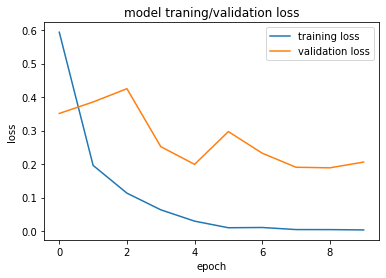

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model traning/validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/newCS230/first_pretrained_model211103_9828")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/newCS230/first_pretrained_model211103_9828/assets


In [ ]:
model2 = keras.models.load_model("/content/drive/MyDrive/newCS230/first_pretrained_model211103_9828")
x_train2, x_val2, y_train2, y_val2 = train_test_split(images, labels, test_size=0.3, random_state=2)
model2.evaluate(x_val2, y_val2)

4/4 [==============================] - 43s 10s/step - loss: 0.0927 - accuracy: 0.9828


[0.0927121639251709, 0.982758641242981]